# Optimal Execution Problem: Liquidation

### Import the necessary libraries

In [ ]:
import numpy as np
import matplotlib
import pandas as pd
from statsmodels.othermod.betareg import BetaModel

from scipy.stats import norm
import matplotlib.dates as md
import matplotlib.pyplot as plt 

from tqdm import tqdm 
import pandas as pd
import time
import datetime as dt

In [ ]:
# import packages

import scipy.io as sio  # for loading matlab data

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.graphics import gofplots
from scipy import stats
from statsmodels.tsa import arima_model
from statsmodels.regression import linear_model

In [ ]:
%matplotlib inline

### Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#data = sio.loadmat('/content/drive/My Drive/MLinFinance/MSFT_20141103.mat')
data = sio.loadmat('/content/drive/Shared drives/ProjectML/Project/MSFT_20141103.mat')

In [ ]:
LOB=data['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*1e-3  #time in seconds, measured from NASDAQ opening at 9:30am
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.0)
nMO = np.array(LOB['NumberMO'][0][0]*1.0)                       #total number of MOs submitted in the given 0.1 second interval
vMO = np.array(LOB['VolumeMO'][0][0]*1.0)                       #total volume of MOs submitted in the given 0.1 second interval
MO=np.array(LOB['MO'][0][0]*1.0)                                #information about market orders
dt = t[1]-t[0]
print(dt)
print(t[0])
print(t[-1])

0.1
0.1
23400.0


## Order Flow

[   3138.   11849.   10366. ... -461685. -462885. -462885.]


([<matplotlib.axis.XTick at 0x7f300ad14760>,
 [Text(0, 0, '9:30'),
  Text(36000, 0, '10:30'),
  Text(72000, 0, '11:30'),
  Text(108000, 0, '12:30'),
  Text(144000, 0, '13:30'),
  Text(180000, 0, '14:30'),
  Text(216000, 0, '15:30')])

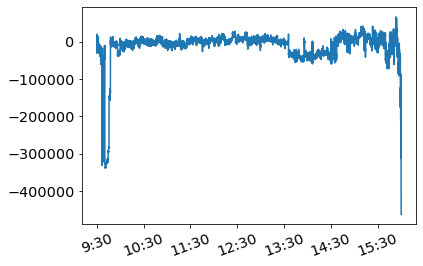

In [ ]:
# Order Flow
order_flow = np.sum(bidvol[:,:10],axis=1)-np.sum(askvol[:,:10],axis=1) # order flow: we take the first 10 columns
print(order_flow)
locs, labels = plt.xticks()  # Get the current locations and labels
plt.plot(order_flow)
plt.xticks([0, 36000, 72000, 108000, 144000, 180000,216000], ['9:30', '10:30', '11:30','12:30','13:30', '14:30', '15:30'], rotation=20)  # Set text labels and properties.

### Prices: Midprice, Microprice and LO Imbalance


In [ ]:
# Midprice
midprice = 0.5*(bid[:,0]+ask[:,0])
#print(midprice)

# Microprice
microprice= (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])
dmicro = microprice[1:]-microprice[:-1]
print(microprice[0:5])
print(dmicro[0:5])
print()
print(len(t))
print(len(dmicro))
print(len(microprice))

# LO imbalance for each time stamp
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T


[46.7306462  46.75261233 46.80596131 46.86008861 46.86783684]
[ 0.02196613  0.05334898  0.0541273   0.00774822 -0.06299407]

234000
233999
234000


### Setting a 2-hours Trading Window: 13:01 to 15:30

In [ ]:
# Work on the trading window

t_init = (211*10*60)-1                              # time for 13:01 am
t_30_min = 30*10*60                                 # 30 minutes: we trade from 13:01 to the (end-30) minutes
N = 60*60*10                                        # Length of estimation window

total_time = len(t)                                 # 234,000 values in the whole day          
trading_time = t[t_init:total_time-t_30_min]        # trading window studied: 1:01pm to 3:30pm
trading_time = trading_time[::10]                   # take every second (for trading)
arr_trading_time = trading_time
trading_time = list(map(int, trading_time))         # integers

# Associated index array in case it is needed
trading_time_indx = trading_time - arr_trading_time[0]  # associate the trading time with an index array in case we need it
trading_time_indx = list(map(int, trading_time_indx))   # integers 

print(trading_time)
print(len(trading_time))
print(trading_time_indx)
print(len(trading_time_indx))


end_trading = trading_time_indx[-1]
T0 = trading_time_indx[0]

[12660, 12661, 12662, 12663, 12664, 12665, 12666, 12667, 12668, 12669, 12670, 12671, 12672, 12673, 12674, 12675, 12676, 12677, 12678, 12679, 12680, 12681, 12682, 12683, 12684, 12685, 12686, 12687, 12688, 12689, 12690, 12691, 12692, 12693, 12694, 12695, 12696, 12697, 12698, 12699, 12700, 12701, 12702, 12703, 12704, 12705, 12706, 12707, 12708, 12709, 12710, 12711, 12712, 12713, 12714, 12715, 12716, 12717, 12718, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12728, 12729, 12730, 12731, 12732, 12733, 12734, 12735, 12736, 12737, 12738, 12739, 12740, 12741, 12742, 12743, 12744, 12745, 12746, 12747, 12748, 12749, 12750, 12751, 12752, 12753, 12754, 12755, 12756, 12757, 12758, 12759, 12760, 12761, 12762, 12763, 12764, 12765, 12766, 12767, 12768, 12769, 12770, 12771, 12772, 12773, 12774, 12775, 12776, 12777, 12778, 12779, 12780, 12781, 12782, 12783, 12784, 12785, 12786, 12787, 12788, 12789, 12790, 12791, 12792, 12793, 12794, 12795, 12796, 12797, 12798, 12799, 12800, 12801, 12802

### Exploration on the trading window without any price impact

In [ ]:
p_star1 = 0.05
p_star3 = 0.05
#freq = 10
predictions_OF = []
accurate_values_OF = []
predictions_OLS = []
accurate_values_microprice = []

# Analysis AR model
p_values_AR = []
phi_list = []
sigma_YW = []

# Analysis OLS
p_values_OLS = []
price_impact_list = []
r_value_list = []
intercept_list = []
std_err_list = []

Performing the statistical tests on estimation window (1-hour) at each second of the trading window\
Tests: Dickey-Fuller \& Linear Regression

In [ ]:
count_phi = 0
for i in range(0,len(trading_time_indx)):
  
  micro_est = microprice[trading_time[i]*10-N:trading_time[i]*10]
  OF_est = order_flow[trading_time[i]*10-N:trading_time[i]*10]

  # Statistical tests on the estimation window (1 hour): ORDER FLOW
  phi, sigma = linear_model.yule_walker(OF_est,order=1)     # Yules-Walker equation
  sigma_YW.append(sigma)
  phi_list.append(phi[0])
  if abs(phi[0])<1:
    count_phi += 1
  
  DF_OF = stattools.adfuller(OF_est,1,'c',None)             # Dickey-Fuller test
  p_value1 = (DF_OF[1])
  p_values_AR.append(p_value1)

  OF_predict = OF_est[-1]*phi[0]**10
  predictions_OF.append(OF_predict)
  accurate_values_OF.append(order_flow[(trading_time[i]+1)*10])

  
  # Linear Regression:
  price_impact, intercept, r_value, p_value3, std_err = stats.linregress(np.diff(OF_est),np.diff(micro_est))

  price_impact_list.append(price_impact)
  intercept_list.append(intercept)
  r_value_list.append(r_value)
  p_values_OLS.append(p_value3)
  std_err_list.append(std_err)

  # Accuracy Linear Regression:
  alpha = price_impact*(1-phi[0]**10)*OF_est[-1]
  S_predict = microprice[10*trading_time[i]] + alpha 
  predictions_OLS.append(S_predict)   
  accurate_values_microprice.append(microprice[10*(trading_time[i]+1)]) 


Comparing Forecast and Actual values from the Linear Regression to get the microprices

<Figure size 432x288 with 0 Axes>

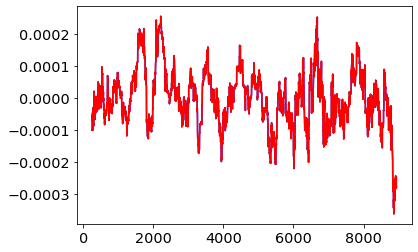

<Figure size 432x288 with 0 Axes>

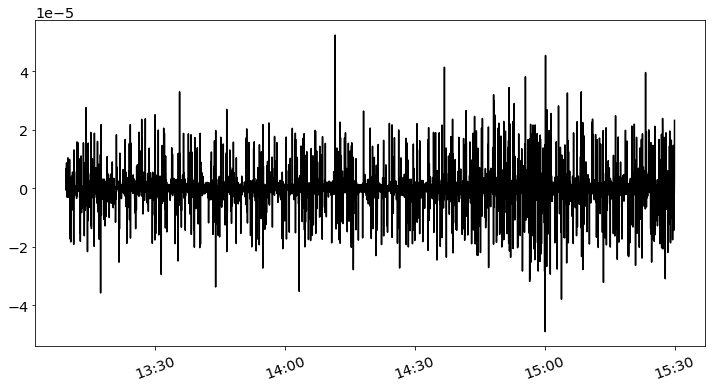

In [ ]:
plt.figure()

df_OLS_pred = pd.DataFrame(predictions_OLS)
df_acc_prices = pd.DataFrame(accurate_values_microprice) 

delta_predictions = np.diff(predictions_OLS)
df_delta_predictions = pd.DataFrame(delta_predictions)

accurate_prices = np.diff(accurate_values_microprice)
df_accurate_prices = pd.DataFrame(accurate_prices)

diff_accurate_prediction = df_accurate_prices - df_delta_predictions

plt.figure()
plt.plot(df_delta_predictions.rolling(250).mean(),'b')
plt.plot(df_accurate_prices.rolling(250).mean(),'r')


plt.figure()
fig, ax = plt.subplots(figsize=(12,6))
locs, labels = plt.xticks()  # Get the current locations and labels
plt.plot(diff_accurate_prediction.rolling(500).mean(),'k')
plt.xticks([1740, 3540, 5340, 7140, 8940], ['13:30', '14:00', '14:30','15:00','15:30'], rotation=20)  # Set text labels and properties.
plt.savefig('/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures/Forecast_Actual_prices.png')

12.132534942650148


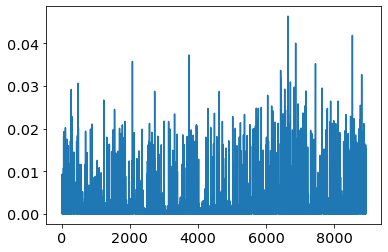

In [ ]:
percentage_prediction = 100*abs((df_acc_prices-df_OLS_pred)/df_acc_prices)
percentage_prediction.columns = ["percentage"]
total_percentage = sum(percentage_prediction["percentage"])
print(total_percentage)
plt.plot(percentage_prediction)

In [ ]:
print(total_percentage/8941)

0.001356955032172033


Comparing Forecast and Actual values from the AR(1) model estimation for the Order Flow

<Figure size 432x288 with 0 Axes>

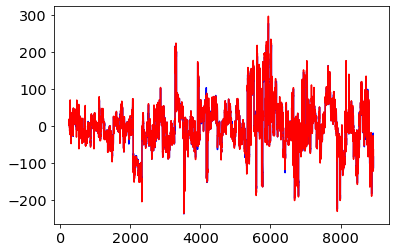

<Figure size 432x288 with 0 Axes>

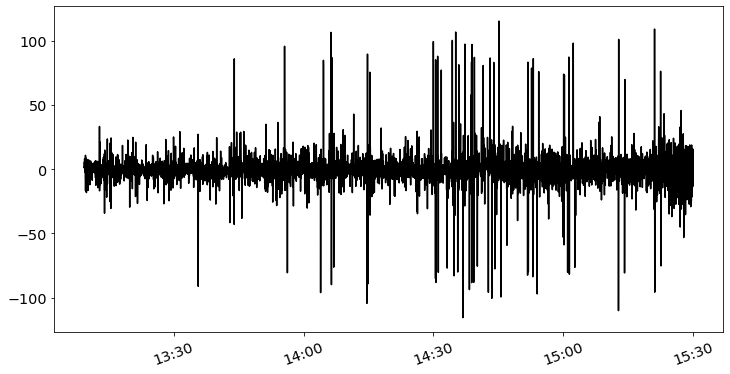

In [ ]:
df_OF_pred = pd.DataFrame(predictions_OF)
df_OF_accurate = pd.DataFrame(accurate_values_OF)

plt.figure()

delta_predictions_OF = np.diff(predictions_OF)
df_delta_predictions_OF = pd.DataFrame(delta_predictions_OF)

accurate_OF = np.diff(accurate_values_OF)
df_accurate_OF = pd.DataFrame(accurate_OF)

diff_accurate_prediction_OF = df_accurate_OF - df_delta_predictions_OF

plt.figure()
plt.plot(df_delta_predictions_OF.rolling(250).mean(),'b')
plt.plot(df_accurate_OF.rolling(250).mean(),'r')


plt.figure()
fig, ax = plt.subplots(figsize=(12,6))
locs, labels = plt.xticks()  # Get the current locations and labels
plt.plot(diff_accurate_prediction_OF.rolling(500).mean(),'k')
plt.xticks([1740, 3540, 5340, 7140, 8940], ['13:30', '14:00', '14:30','15:00','15:30'], rotation=20)  # Set text labels and properties.
plt.savefig('/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures/Forecast_Actual_OF.png')

In [ ]:
percentage_OF = 100*(abs(df_OF_accurate-df_OF_pred))/df_OF_accurate
percentage_OF.columns = ["percentage"]
total_percentage_OF = sum(percentage_OF["percentage"])
print(total_percentage_OF)

66302.05414238435


In [ ]:
print(total_percentage_OF/8941)

7.415507677260301
